# Model AI terkait Stunting akibat Malnutrisi dan lainnya di Kab. Mamberamo Raya

## Point of View

Masalah malnutrisi di Distrik Mamberamo merupakan persoalan serius yang berdampak langsung pada perkembangan fisik, kognitif, dan produktivitas generasi muda di wilayah tersebut. Tantangan ini semakin berat karena kombinasi antara keterbatasan akses layanan kesehatan, letak geografis yang terpencil, serta keterbatasan data dan pemantauan secara real-time terkait status gizi anak-anak. Data yang akurat dan terklasifikasi dengan baik sangat dibutuhkan untuk memastikan intervensi yang tepat sasaran dan cepat.

Dari sudut pandang teknologi, kemajuan kecerdasan buatan (AI) menghadirkan peluang besar untuk mengatasi kendala klasik pada sistem konvensional. Dengan pemodelan klasifikasi berbasis AI, data kesehatan seperti usia, berat badan, tinggi badan, dan faktor lingkungan dapat diproses secara otomatis dan cepat. Dengan metode ini, kita dapat lebih mudah mengidentifikasi kelompok rentan, memprioritaskan penanganan, serta memonitor perkembangan atau memburuknya kasus malnutrisi secara dinamis.

Maka, pengembangan model klasifikasi menjadi sangat penting di Distrik Mamberamo. Model ini dapat menjadi dasar sistem peringatan dini, membantu tenaga kesehatan dalam mengambil keputusan, serta mendukung pemerintah dalam distribusi sumber daya yang terbatas secara efektif. Dengan adanya model klasifikasi, deteksi dini dan respon cepat dapat dilakukan, sehingga potensi dampak buruk akibat malnutrisi dapat diminimalisir dan kualitas hidup masyarakat dapat meningkat secara berkelanjutan.

# Inisialisasi Package

In [1]:
# General Package
import io
import logging
import warnings
import pandas as pd
import numpy as np
from copy import deepcopy
from google.colab import drive

warnings.filterwarnings('ignore')
pd.options.display.float_format = '{:,.2f}'.format
np.random.seed(1)

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
#sns.set_style('darkgrid')
plt.style.use('fivethirtyeight')
plt.rcParams['lines.linewidth'] = 1.5
dark_style = {
    'figure.facecolor': '#212946',
    'axes.facecolor': '#212946',
    'savefig.facecolor':'#212946',
    'axes.grid': True,
    'axes.grid.which': 'both',
    'axes.spines.left': False,
    'axes.spines.right': False,
    'axes.spines.top': False,
    'axes.spines.bottom': False,
    'grid.color': '#2A3459',
    'grid.linewidth': '1',
    'text.color': '0.9',
    'axes.labelcolor': '0.9',
    'xtick.color': '0.9',
    'ytick.color': '0.9',
    'font.size': 12 }
plt.rcParams.update(dark_style)

from pylab import rcParams
rcParams['figure.figsize'] = (12,6)

# Fungsi Visualisasi

In [3]:
from bokeh.models import HoverTool, ColumnDataSource, NumeralTickFormatter, DatetimeTickFormatter
from bokeh.io import curdoc, output_notebook
from bokeh.themes import built_in_themes
from bokeh.plotting import figure, show
from bokeh.palettes import gray
from bokeh.colors import RGB

output_notebook()
curdoc().theme = built_in_themes['caliber']

In [4]:
def BokehPlot_1D(data: pd.DataFrame,
                 dates: str = 'date',
                 original: str = 'suhu',
                 Title: str = 'Grafik Suhu Harian',
                 Color: str = '#0a8234',
                 date_unit: str = 'day', # Opsi Argumen: 'year', 'month', 'day'
                ) -> None:
    output_notebook()
    curdoc().theme = built_in_themes['caliber']

    yourdata = data.copy()
    if dates not in yourdata.columns:
        yourdata[dates] = yourdata.index


    # Grafik inisialisasi
    Grafik = figure(title=Title,
                    background_fill_color=RGB(242, 242, 242),
                    background_fill_alpha=0.85,
                    )
    Grafik.width = 1200
    Grafik.height = 400

    # Modifikasi Data
    if date_unit == 'month':
        yourdata['Penanggalan'] = pd.to_datetime(yourdata[dates], format='%Y-%m', errors='coerce')
        Grafik.xaxis.formatter = DatetimeTickFormatter(months="%b %Y")
        x_axis_label = 'Bulan'
        hover_format = "@tanggal{%b %Y}"
    elif date_unit == 'year':
        yourdata['Penanggalan'] = pd.to_datetime(yourdata[dates], format='%Y', errors='coerce')
        Grafik.xaxis.formatter = DatetimeTickFormatter(years="%Y")
        x_axis_label = 'Tahun'
        hover_format = "@tanggal{%Y}"
    else:
        yourdata['Penanggalan'] = pd.to_datetime(yourdata[dates], format='%Y-%m-%d', errors='coerce')
        Grafik.xaxis.formatter = DatetimeTickFormatter(days="%d %b %Y")
        x_axis_label = 'Harian'
        hover_format = "@tanggal{%d %b %Y}"

    Grafik.xaxis.axis_label = x_axis_label
    Grafik.yaxis.axis_label = original

    # Join dataset ke Source
    yourdata.dropna(subset=['Penanggalan'], inplace=True)
    source = ColumnDataSource(data=dict(
        tanggal=yourdata['Penanggalan'],
        Original=yourdata[original],
    ))

    Grafik.line(x='tanggal', y='Original',
                source=source, legend_label=original.upper(),
                line_width=2, color=Color)

    # Hover setting
    Tipo = HoverTool()
    Tipo.tooltips = [(x_axis_label, hover_format),
                     ("Origin",   "@Original{0,.2f}"),
                    ]
    Tipo.formatters = {'@tanggal': 'datetime'}
    Tipo.mode = 'vline'
    Grafik.add_tools(Tipo)

    # Customize plot
    Grafik.title.align = 'center'
    Grafik.title.text_font_size = '20pt'
    Grafik.title.text_color = '#d11950'
    Grafik.legend.location = 'top_left'
    Grafik.legend.click_policy = 'hide'

    Grafik.yaxis.formatter = NumeralTickFormatter(format="0,0")
    show(Grafik)

In [5]:
def Bokeh_Decomposition(DataX : np.ndarray,
                        DataY : np.ndarray,
                        Judul : str = 'Komponen Trend',
                        color : str = "#d11950",
                       ) -> None :
    Data = ColumnDataSource(data=dict(
                              x = DataX,
                              y = DataY,
                            ))

    graphDeretWaktu = figure(width        = 1200,
                             height       = 250,
                             x_axis_type  = "datetime",
                             x_axis_label = "Tanggal",
                             y_axis_label = "Nilai",
                             background_fill_color = gray(20)[17],
                             background_fill_alpha = 0.85,
                            )

    graphDeretWaktu.line('x', 'y',
                         source     = Data,
                         color      = color,
                         line_width = 1,
                        )
    graphDeretWaktu.title.text           = Judul
    graphDeretWaktu.title.text_font_size = "20pt"
    graphDeretWaktu.title.align          = "center"
    graphDeretWaktu.title.text_color     = color
    graphDeretWaktu.yaxis[0].formatter = NumeralTickFormatter(format="0,0")

    THeHover = HoverTool(tooltips=[
                        ("Tanggal", "@x{%F}"),
                        ("Nilai", "@y{0,.2f}")],
                        formatters={"@x": "datetime"
                        })
    graphDeretWaktu.add_tools(THeHover)
    show(graphDeretWaktu)


In [6]:
def BokehPlot(mydata      : pd.DataFrame,
              dates       : str = 'date',
              original    : str = 'Close',
              prediksi    : str = 'Forecasting',
              batas_atas  : str = 'AutoARIMA-hi-95',
              batas_bawah : str = 'AutoARIMA-lo-95',
              modelname   : str = 'ARIMA',
              title       : str = '',
             ) -> None :

    output_notebook()
    curdoc().theme = built_in_themes['caliber']

    yourdata = mydata.copy()
    if dates not in yourdata.columns:
        yourdata[dates] = yourdata.index

    if batas_atas not in yourdata.columns:
        data_dict = {
            'tanggal': yourdata[dates],
            'Original': yourdata[original],
            'Predict': yourdata[prediksi]
        }
        varea = False
    else:
        data_dict = {
            'tanggal': yourdata[dates],
            'Original': yourdata[original],
            'Predict': yourdata[prediksi],
            'upper':yourdata[batas_atas],
            'lower':yourdata[batas_bawah],
        }
        varea = True
    DataSumber = ColumnDataSource(data=data_dict)

    if len(str(title)) <= 5 :
        title = f'Plot {modelname} dalam data Order Demand'
    Grafik = figure(title= title,
                    x_axis_type='datetime',
                    x_axis_label='Tanggal',
                    y_axis_label='Besar Order Demand',
                    background_fill_color=gray(20)[17],
                    background_fill_alpha=0.85,
                    )
    Grafik.width = 1200
    Grafik.height = 400

    Grafik.line(x='tanggal', y='Original',
                source=DataSumber, legend_label='Besar Order Demand pada Gudang',
                line_width=2, color='#252392')
    Grafik.line(x='tanggal', y='Predict',
                source=DataSumber, legend_label=f'{modelname}',
                line_width=2, color='#d40d4c')
    if varea :
        Grafik.varea(x='tanggal',
                     y1='lower',
                     y2='upper',
                     source=DataSumber,
                     color='#61e041',
                     alpha=0.7,
                     legend_label='95% CI'
                    )

    Tipo = HoverTool()
    Tipo.tooltips = [("Tanggal", "@tanggal{%F}"),
                     ("Origin", "@Original{0,.2f}"),
                     (modelname, "@Predict{0,.2f}"),
                     ]
    Tipo.formatters = {'@tanggal': 'datetime'}
    Grafik.add_tools(Tipo)

    Grafik.title.align = 'center'
    Grafik.title.text_font_size = '20pt'
    Grafik.title.text_color = '#d11950'
    Grafik.legend.location = 'top_left'
    Grafik.legend.click_policy = 'hide'
    Grafik.yaxis.formatter = NumeralTickFormatter(format="0,0")

    show(Grafik)

# Inisialisasi Data

In [7]:
drive.mount('/content/Jack', force_remount = True)

Mounted at /content/Jack


In [17]:
import os
import zipfile as zp

def ZipExtract(zpath : str,
               paswd : str,
               where : str,
              ) -> None :
    try:
        with zp.ZipFile(zpath, 'r') as f:
            f.setpassword(paswd.encode('utf-8'))
            f.extractall(where)
        print(f"File '{zpath}' berhasil diekstrak.")
        print('Berikut list directory-nya:')
        print(os.listdir(where))
        return os.path.realpath(os.path.join(where, 'StuntingData.xlsx'))
    except zp.BadZipFile:
        print(f"Error: File '{zpath}' bukan file ZIP yang valid atau rusak.")
    except RuntimeError as Arch:
        if "Bad password" in str(Arch):
            print(f"Error: Kata sandi salah untuk file '{zpath}'.")
        else:
            print(f"Error saat mengekstrak file: {Arch}")
    except FileNotFoundError:
        print(f"Error: File '{zpath}' tidak ditemukan.")
    except Exception as Arch:
        print(f"Terjadi kesalahan tak terduga: {Arch}")

In [20]:
Zippath = '/content/Jack/MyDrive/LECTURE/PAPER 01/StuntingData.zip'
#Excelpath = ZipExtract(Zippath, '*******', './')

In [21]:
ExcelPath = '/content/Jack/MyDrive/LECTURE/PAPER 01/StuntingData.xlsx'
Data = pd.read_excel(ExcelPath)

In [22]:
Data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 607 entries, 0 to 606
Data columns (total 11 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   No                607 non-null    int64 
 1   DistrikKecamatan  607 non-null    object
 2   Kec_Kode          607 non-null    int64 
 3   Y                 607 non-null    int64 
 4   X1                607 non-null    int64 
 5   X2                607 non-null    int64 
 6   X3                607 non-null    int64 
 7   X4                607 non-null    int64 
 8   X5                607 non-null    int64 
 9   X6                607 non-null    int64 
 10  X7                607 non-null    int64 
dtypes: int64(10), object(1)
memory usage: 52.3+ KB


Berikut ini adalah detail dari setiap fitur pada data kita.

| Variable | Nama Variable | Skala| Kategori | Definisi Operasional |
|---|---|---|---|---|
| Y| Stunting| Nominal| 1 = Stunting 0 = Tidak Stunting | Kondisi gagal tumbuh pada anak balita akibat kekurangan gizi kronis yang terjadi dalam jangka waktu panjang, terutama pada 1.000 hari pertama kehidupan (sejak dalam kandungan hingga usia dua tahun).|
| X1 | Jenis kelamin | Nominal| 1 = Laki-laki 0 = Perempuan | Suatu ciri biologis yang membedakan antara laki-laki dan perempuan yang ditentukan sejak lahir.|
| X2 | Level Status Gizi Buruk menurut WHO | Nominal | 0 - 6 dengan 6 sangat bergizi buruk | Status gizi menurut WHO adalah suatu keadaan yang diakibatkan oleh keseimbangan antara asupan gizi dari makanan dengan kebutuhan nutrisi yang diperlukan tubuh untuk metabolism. |
| X3 | ASI Eksklusif | Nominal| 1 = Tidak ASI Eksklusif 0 = ASI Eksklusif | Pemberian hanya Air Susu Ibu kepada bayi sejak lahir hingga berusia 6 bulan tanpa tambahan makanan/minuman lain (kecuali obat/vitamin sesuai anjuran medis).|
| X4 | Kebiasaan Merokok Dalam Keluarga | Nominal| 1 = Ada Kebiasaan Merokok 0 = Tidak Ada Kebiasaan Merokok | Kondisi di mana terdapat satu atau lebih anggota keluarga yang secara rutin merokok, baik di dalam maupun di sekitar lingkungan rumah tempat anak tinggal. |
| X5 | Akses Air Bersih| Nominal| 1 = Tidak Ada Akses Air Bersih 0 = Ada Akses Air Bersih | Kondisi ketersediaan air yang layak dikonsumsi/digunakan sehari-hari. Air bersih berasal dari sumber memenuhi syarat kesehatan (PDAM, sumur/mata air terlindung, air hujan yang dikelola). |
| X6 | Jamban Sehat| Nominal| 1 = Tidak Ada Jamban Sehat 0 = Ada Jamban Sehat | Fasilitas sanitasi memenuhi syarat kesehatan: punya leher angsa (water seal), penutup, saluran tertutup, tidak mencemari air. |
| X7 | Wilayah Sulit | Nominal| 1 = Sulit 0 = Tidak Sulit | Kategori geografis menggambarkan daerah dengan keterbatasan akses infrastruktur dasar, baik karena kondisi geografis berat, terbatas transportasi, atau jauh dari pusat pelayanan publik. |

# Penyimpanan Data pada DuckDB

In [ ]:
import duckdb

PathDB = '/content/Jack/MyDrive/Malnutrition_Paper.db'
DuckConnect = duckdb.connect(database = PathDB)

In [ ]:
NameVar = ["IDs", "District_Name", "District_Code", "Stunting",
           "Gender", "Malnutrition_Level", "Exclusive_Milky",
           "Smoke_Habit", "PureWater_Access", "Healthy_Toilet",
           "Difficult_Acess"]
Data.columns = NameVar

In [ ]:
DataProc = Data.copy()
DataProc.drop(columns = ['IDs', 'District_Code'], inplace = True)
DataProc.reset_index(drop = True, inplace = True)

In [ ]:
DataProc.head(3)

,District_Name,Stunting,Gender,Malnutrition_Level,Exclusive_Milky,Smoke_Habit,PureWater_Access,Healthy_Toilet,Difficult_Acess
0,BENUKI,1,0,2,1,1,0,0,1
1,BENUKI,0,0,1,1,1,0,1,1
2,BENUKI,1,1,6,1,1,1,0,1


In [ ]:
DuckConnect.execute('DROP TABLE IF EXISTS RawData;')
DuckConnect.execute('CREATE TABLE RawData AS SELECT * FROM DataProc;')

In [ ]:
DataProc.describe().T

,count,mean,std,min,25%,50%,75%,max
Stunting,607.00,0.54,0.50,0.00,0.00,1.00,1.00,1.00
Gender,607.00,0.57,0.50,0.00,0.00,1.00,1.00,1.00
Malnutrition_Level,607.00,1.45,1.18,0.00,1.00,1.00,2.00,6.00
Exclusive_Milky,607.00,0.53,0.50,0.00,0.00,1.00,1.00,1.00
Smoke_Habit,607.00,0.49,0.50,0.00,0.00,0.00,1.00,1.00
PureWater_Access,607.00,0.47,0.50,0.00,0.00,0.00,1.00,1.00
Healthy_Toilet,607.00,0.32,0.47,0.00,0.00,0.00,1.00,1.00
Difficult_Acess,607.00,0.71,0.45,0.00,0.00,1.00,1.00,1.00


In [ ]:
def NullData(ourData : pd.DataFrame) -> pd.DataFrame:
    miss         = ourData.isnull().sum()
    miss         = miss[miss > 0]
    miss_percent = 100 * miss / len(ourData)
    allmiss      = pd.concat([miss, miss_percent], axis=1)
    allmiss      = allmiss.rename(columns =
                   {0: 'Nilai Hilang', 1: 'Persentase'})
    allmiss      = allmiss.sort_values(by='Persentase',
                    ascending = False)
    return allmiss

In [ ]:
print('Banyaknya Missing Data adalah:')
display(NullData(DataProc))

Banyaknya Missing Data adalah:


,Nilai Hilang,Persentase


# Korelasi Data

In [ ]:
from scipy.stats import spearmanr

Temps = DataProc.select_dtypes(include = np.number)
CorrVals, _ = spearmanr(Temps)
CorrDF      = pd.DataFrame(CorrVals, index = Temps.columns, columns = Temps.columns)

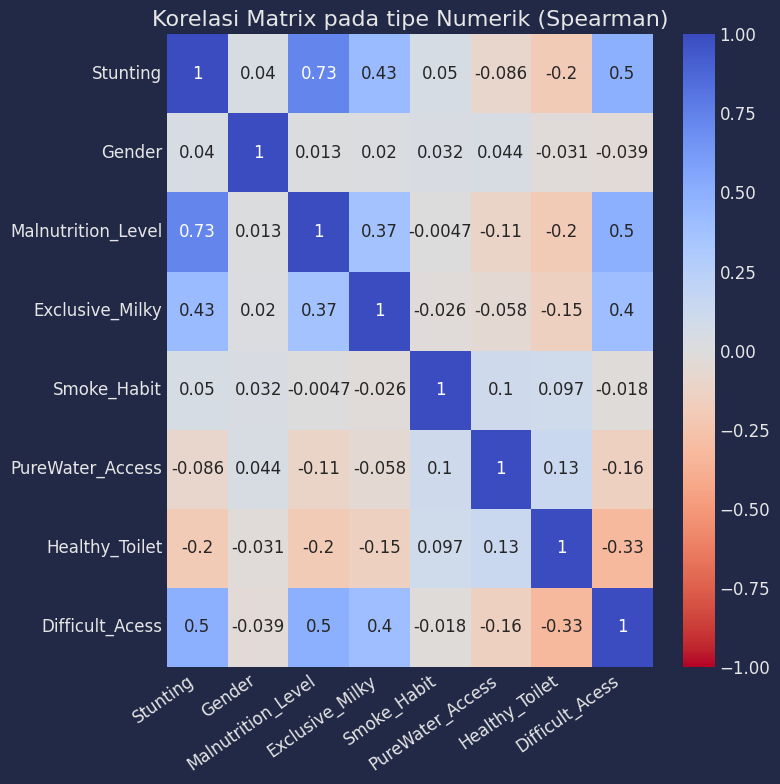

In [ ]:
fig, ax = plt.subplots(figsize=(8, 8))
sns.heatmap(CorrDF, annot=True, vmin = -1, vmax = 1, cmap='coolwarm_r', ax = ax)
ax.set_title('Korelasi Matrix pada tipe Numerik (Spearman)', fontsize=16)
plt.xticks(rotation=35, ha='right')
plt.tight_layout()
plt.show()

# Visualisasi Data

In [ ]:
Groups = Data.groupby(['Stunting', 'Malnutrition_Level']).size().reset_index(name = 'Count')
display(Groups)

,Stunting,Malnutrition_Level,Count
0,0,0,106
1,0,1,173
2,1,0,18
3,1,1,54
4,1,2,176
5,1,3,38
6,1,4,27
7,1,5,11
8,1,6,4


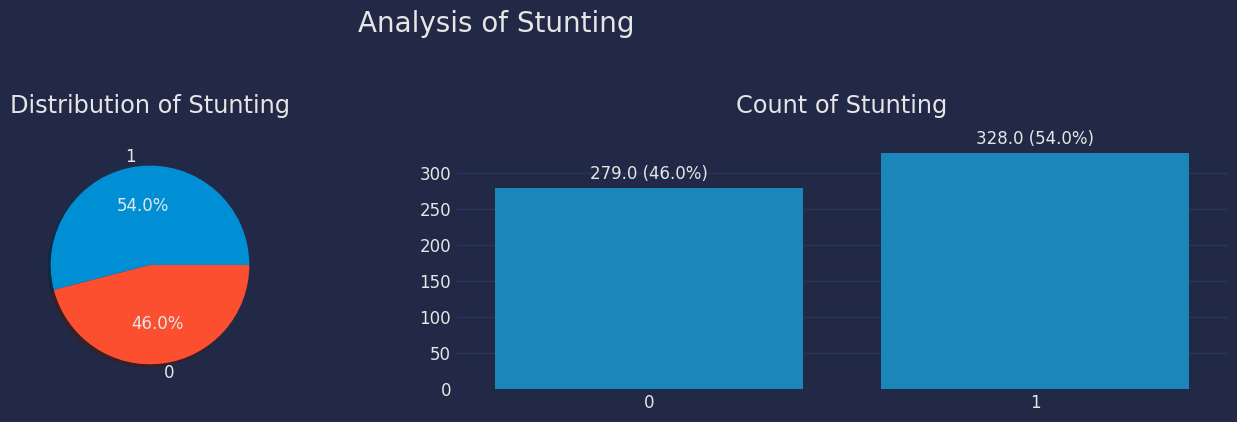

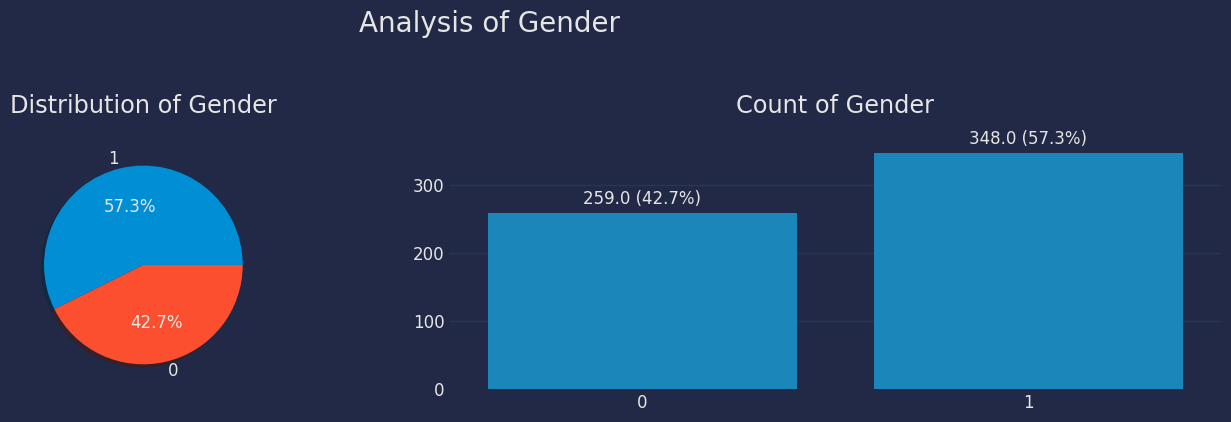

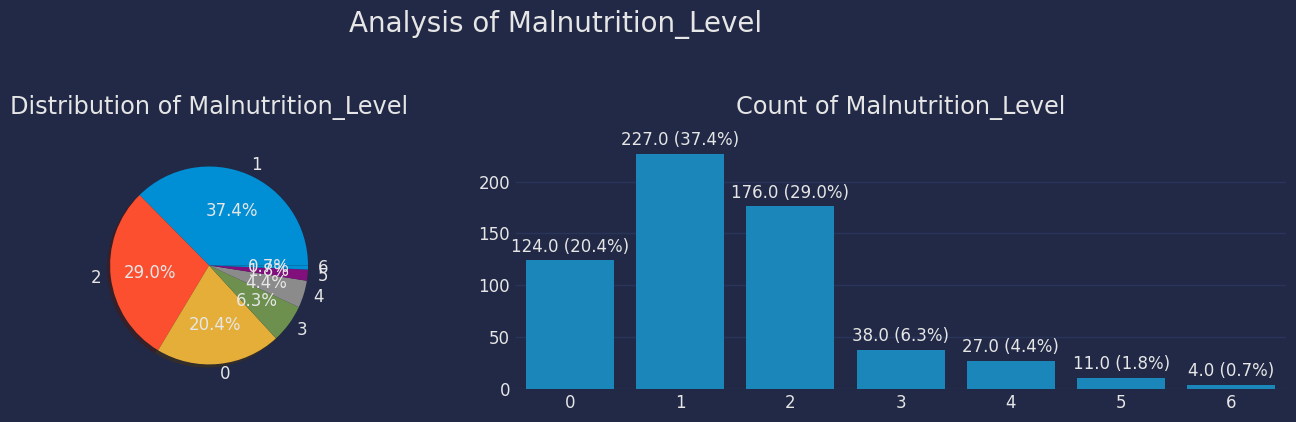

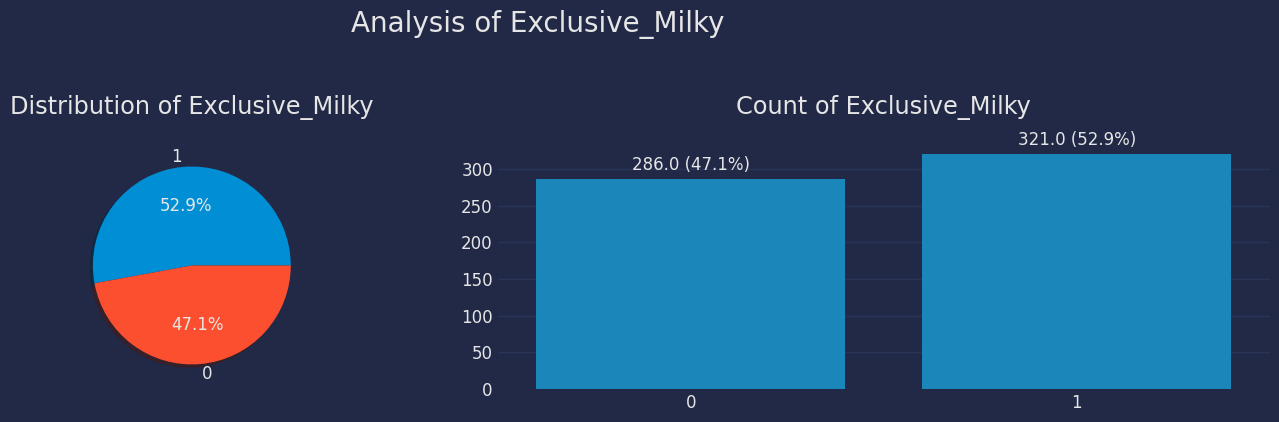

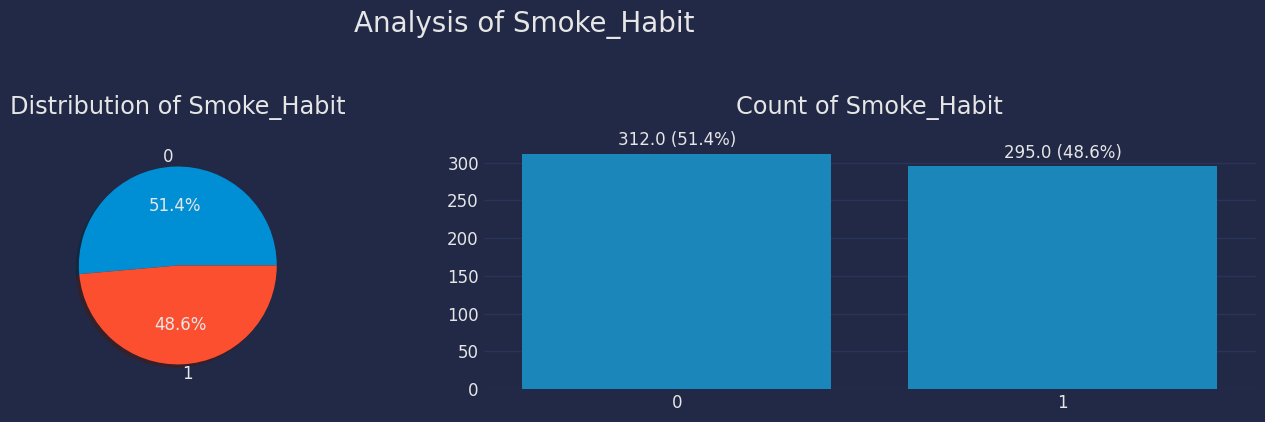

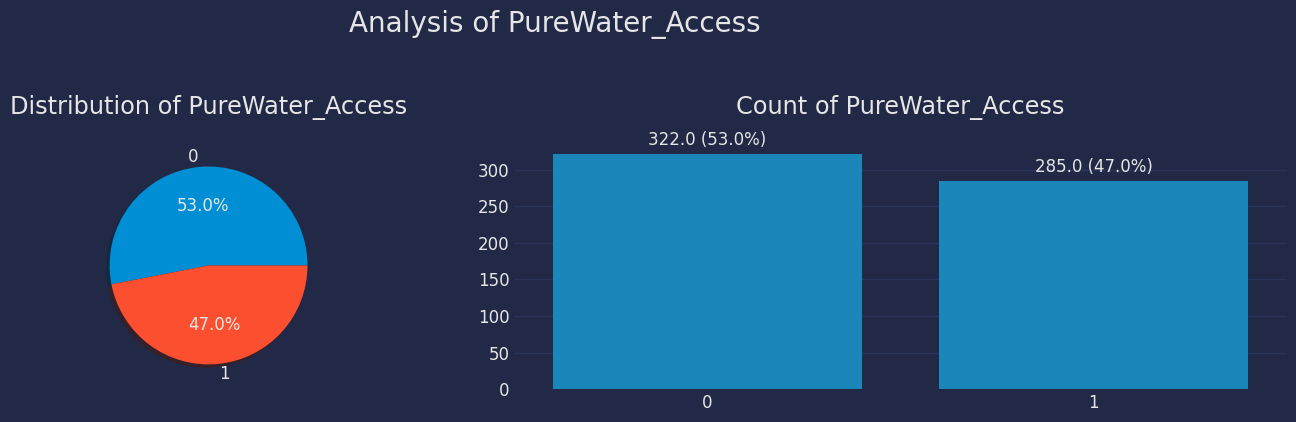

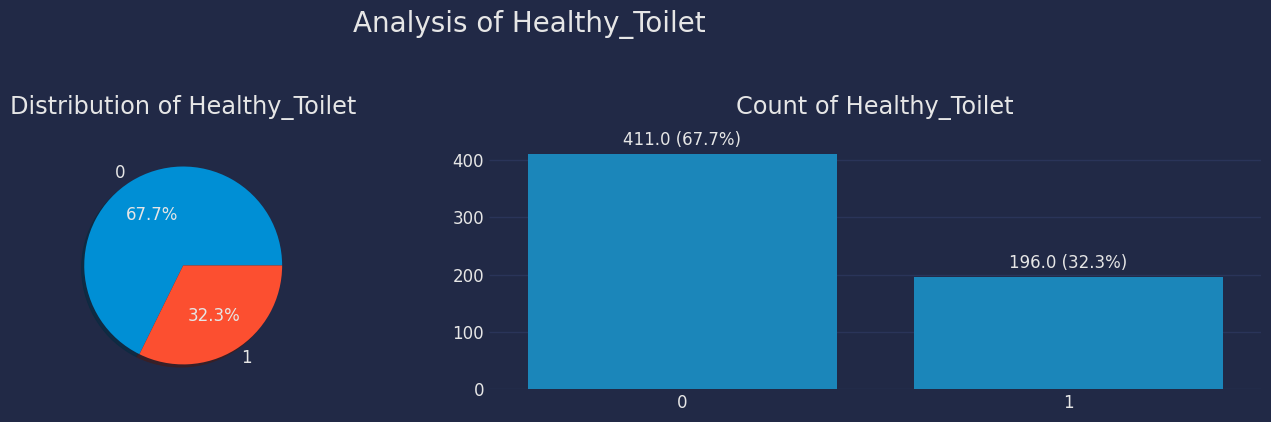

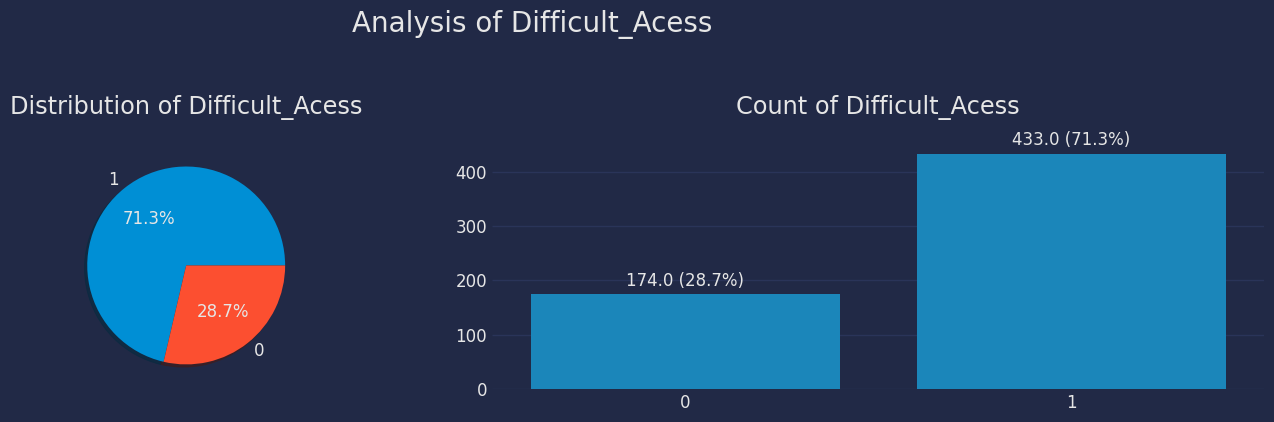

In [ ]:
Category = ['Stunting', 'Gender', 'Malnutrition_Level', 'Exclusive_Milky',
            'Smoke_Habit', 'PureWater_Access', 'Healthy_Toilet', 'Difficult_Acess']

for item in Category:
    f, ax = plt.subplots(1, 2, figsize=(15, 4))

    # Pie chart
    DataProc[item].value_counts().plot.pie(autopct='%1.1f%%', ax=ax[0], shadow=True)
    ax[0].set_ylabel('')
    ax[0].set_title(f'Distribution of {item}', pad=20)

    # Bar plot
    sns.countplot(x=item, data=DataProc, ax=ax[1])
    ax[1].set_ylabel('')
    ax[1].set_xlabel('')
    ax[1].set_title(f'Count of {item}', pad=20)

    # annotations
    total = len(DataProc[item])
    for p in ax[1].patches:
        height = p.get_height()
        ax[1].annotate(f'{height} ({height/total:.1%})',
                      (p.get_x() + p.get_width() / 2., height),
                      ha='center', va='center',
                      xytext=(0, 10),
                      textcoords='offset points')

    plt.suptitle(f'Analysis of {item}', size=20, y=1.05)
    sns.despine(left=True, bottom=True)
    plt.tight_layout()
    plt.show()

In [ ]:
Groups01 = DataProc.groupby(['District_Name', 'Stunting']).size().reset_index(name = 'Count')
pivot_df = Groups01.pivot(index='District_Name', columns='Stunting', values='Count').fillna(0)
pivot_df

Stunting,0,1
District_Name,,
BENUKI,18,33
MAMBERAMO HILIR,45,20
MAMBERAMO HULU,28,7
MAMBERAMO TENGAH,104,16
MAMBERAMO TENGAH TIMUR,16,3
SAWAI,34,107
WAROPEN ATAS,34,142


In [ ]:
from math import pi
from bokeh.plotting import figure
from bokeh.io import output_notebook, show
from bokeh.transform import dodge
from bokeh.models import ColumnDataSource, HoverTool
output_notebook()

Groups01 = DataProc.groupby(['District_Name', 'Stunting']).size().reset_index(name = 'Count')
pivot_df = Groups01.pivot(index='District_Name', columns='Stunting', values='Count').fillna(0)

# Tambahkan kolom nama district sebagai kolom biasa untuk source Bokeh - REMOVED THIS LINE
# pivot_df['District_Name'] = pivot_df.index

data_dict = {
            'tanggal': yourdata[dates],
            'Original': yourdata[original],
            'Predict': yourdata[prediksi],
            'upper':yourdata[batas_atas],
            'lower':yourdata[batas_bawah],
        }
DataSumber = ColumnDataSource(data=data_dict)

Grafik = figure(title= title,
                x_axis_type='datetime',
                x_axis_label='Tanggal',
                y_axis_label='Besar Order Demand',
                background_fill_color=gray(20)[17],
                background_fill_alpha=0.85,
                )
Grafik.width = 1200
Grafik.height = 400

source = ColumnDataSource(pivot_df)

# Buat figure dengan x_range sesuai district names
districts = list(pivot_df.index)
p = figure(x_range=districts, height=500, width=1200, title="Jumlah Anak Balita Stunting dan Tidak Stunting per District",
           toolbar_location=None, tools="")

# Lebar bar tiap kategori
bar_width = 0.4

# Buat vbar kelompok "Tidak Stunting"
non_stunting_bars = p.vbar(x=dodge('District_Name', -bar_width/2, range=p.x_range), top='Tidak Stunting', width=bar_width,
       source=source, color="#718dbf", legend_label="Tidak Stunting", name="Tidak Stunting")

# Buat vbar kelompok "Stunting"
stunting_bars = p.vbar(x=dodge('District_Name', bar_width/2, range=p.x_range), top='Stunting', width=bar_width,
       source=source, color="#e84d60", legend_label="Stunting", name="Stunting")

# Atur atribut sumbu x
p.x_range.range_padding = 0.05
p.xgrid.grid_line_color = None
p.y_range.start = 0
p.xaxis.major_label_orientation = pi/6

# Tambahkan hover tool dan kaitkan dengan renderers
hover = HoverTool(renderers=[non_stunting_bars, stunting_bars],
                  tooltips=[
                      ("District", "@District_Name"),
                      ("Kategori", "$name"),
                      ("Jumlah", "@$name")
                  ])
p.add_tools(hover)


p.legend.location = "top_right"
p.legend.click_policy = "hide"

show(p)

ValueError: failed to validate ColumnDataSource(id='p1003', ...).data: expected a dict of type ColumnData(String, Seq(Any)), got a dict with invalid keys: 0, 1

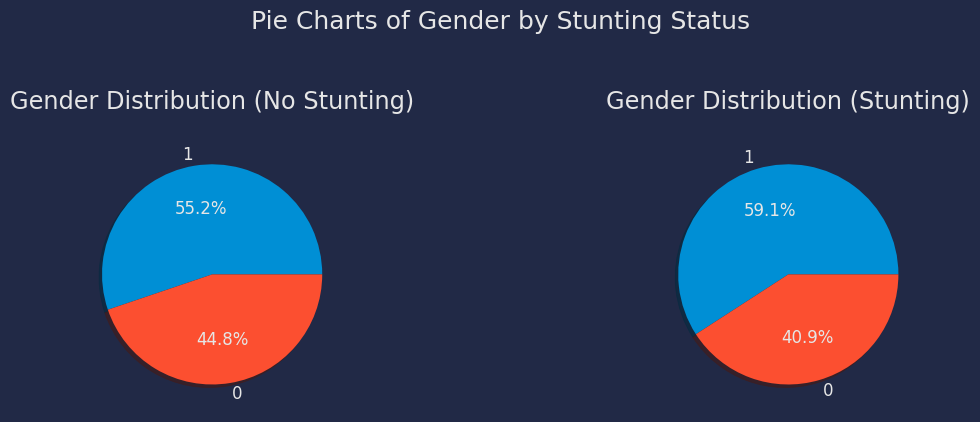

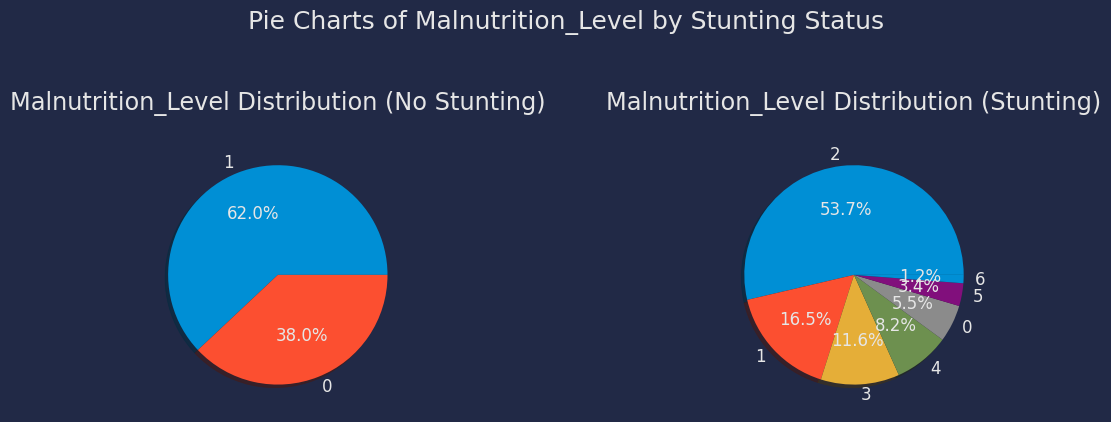

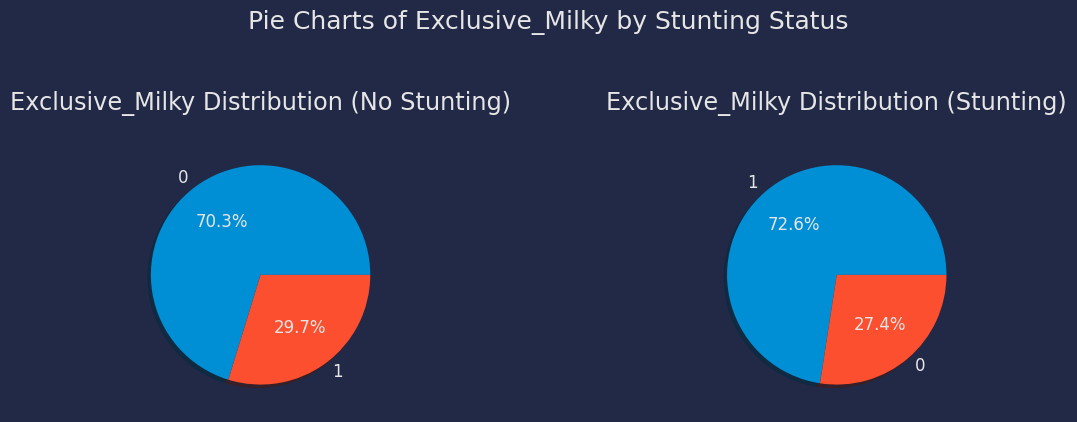

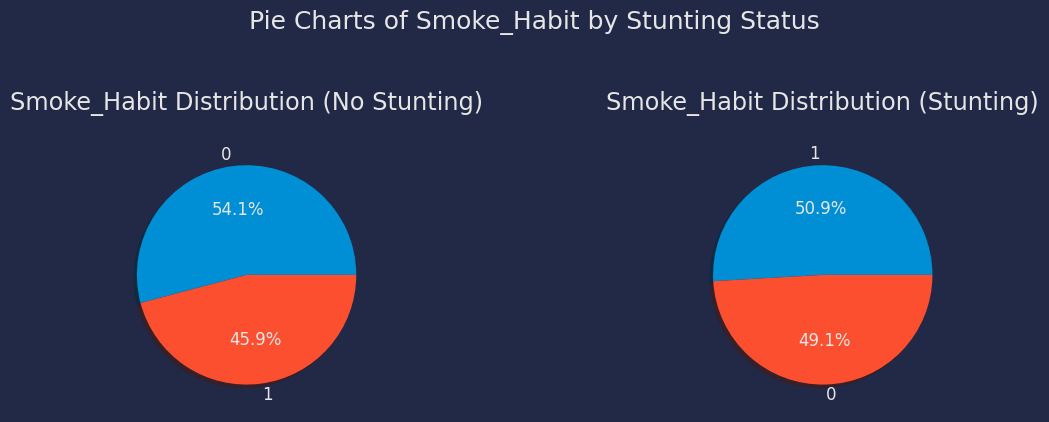

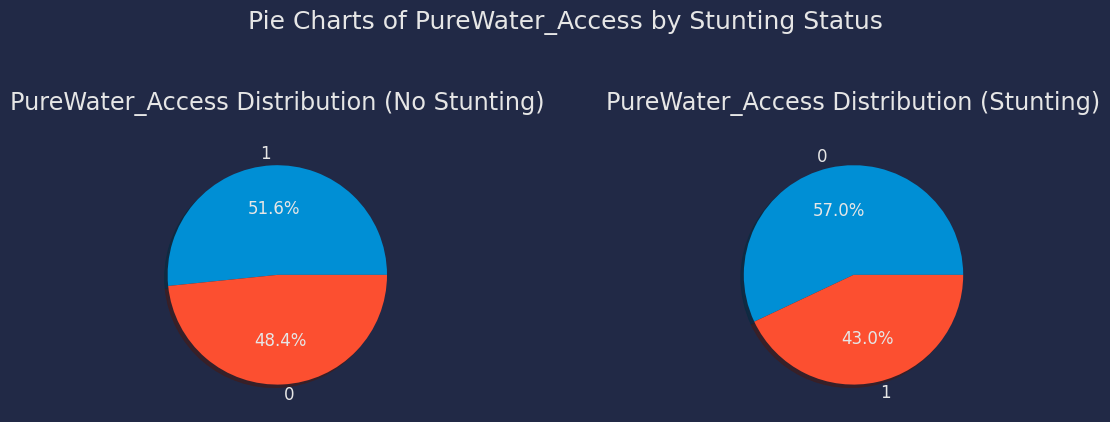

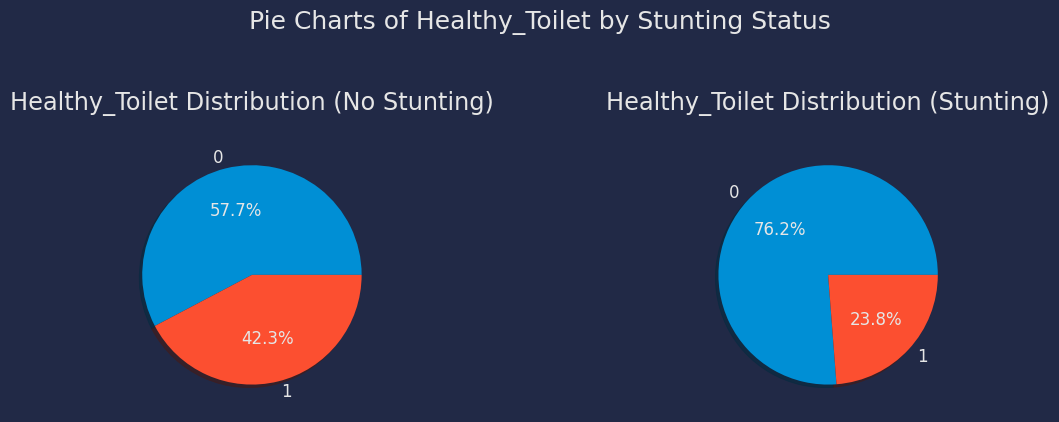

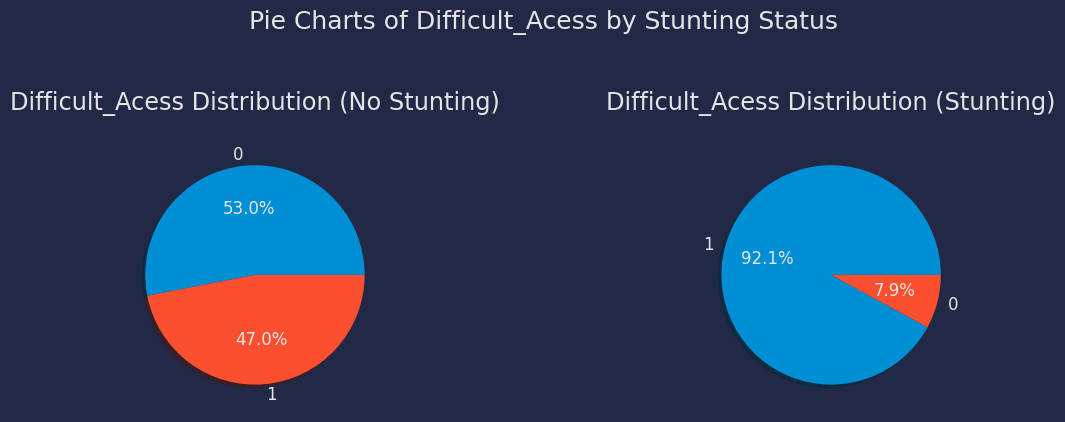

In [ ]:
# List of features to analyze
features = ['Gender', 'Malnutrition_Level', 'Exclusive_Milky',
            'Smoke_Habit', 'PureWater_Access', 'Healthy_Toilet', 'Difficult_Acess']

for feature in features:
    # Create figure with 1 row and 2 columns
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 4))

    # First subplot: Two pie charts side by side for Stunting=0 and Stunting=1
    stunting_groups = DataProc.groupby('Stunting')[feature].value_counts(normalize=True).unstack()

    # Pie chart for Stunting=0
    DataProc[DataProc['Stunting'] == 0][feature].value_counts().plot.pie(
        autopct='%1.1f%%', ax=ax1, shadow=True)
    ax1.set_title(f'{feature} Distribution (No Stunting)', pad=20)
    ax1.set_ylabel('')

    # Pie chart for Stunting=1
    DataProc[DataProc['Stunting'] == 1][feature].value_counts().plot.pie(
        autopct='%1.1f%%', ax=ax2, shadow=True)
    ax2.set_title(f'{feature} Distribution (Stunting)', pad=20)
    ax2.set_ylabel('')

    plt.suptitle(f'Pie Charts of {feature} by Stunting Status', size=18, y=1.05)
    plt.tight_layout()
    plt.show()

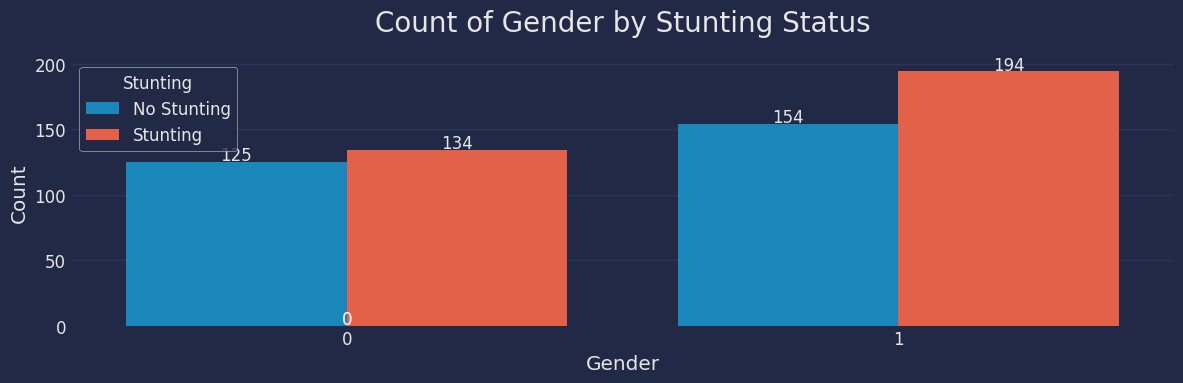

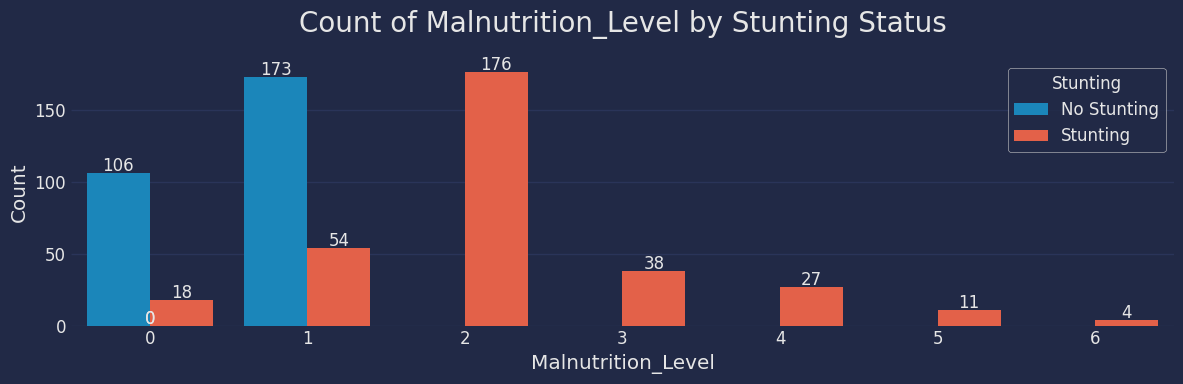

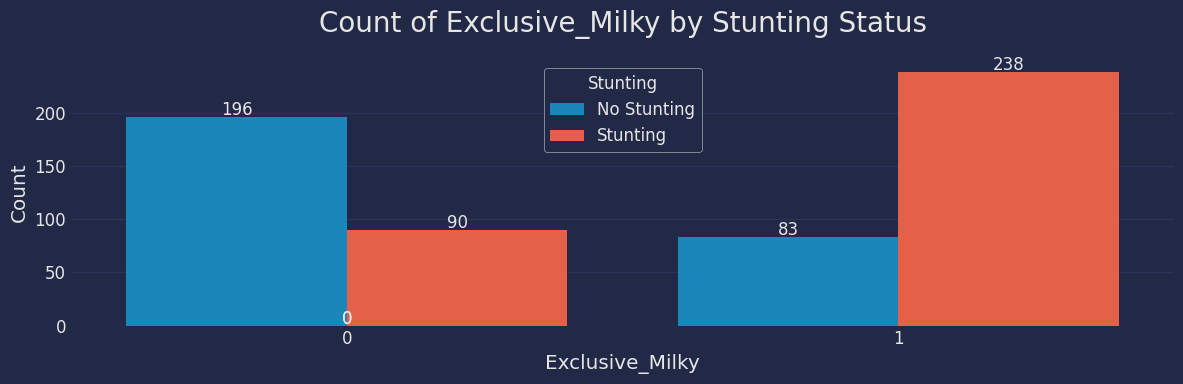

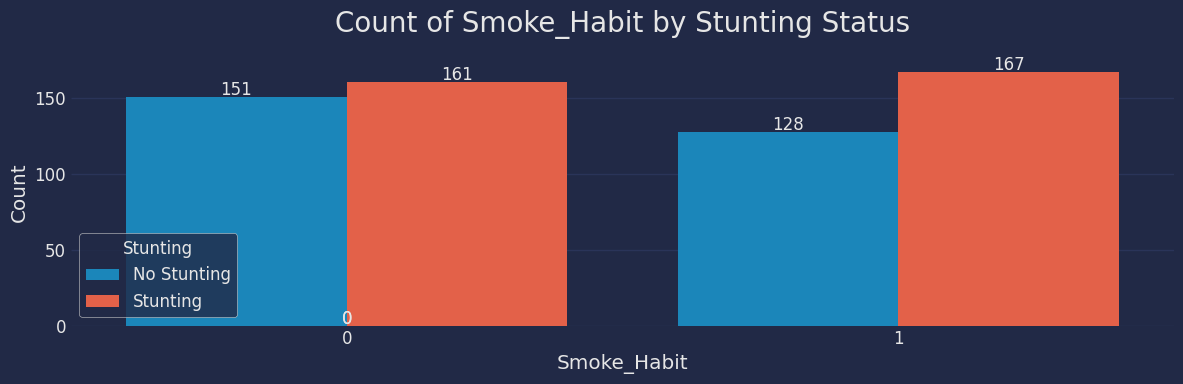

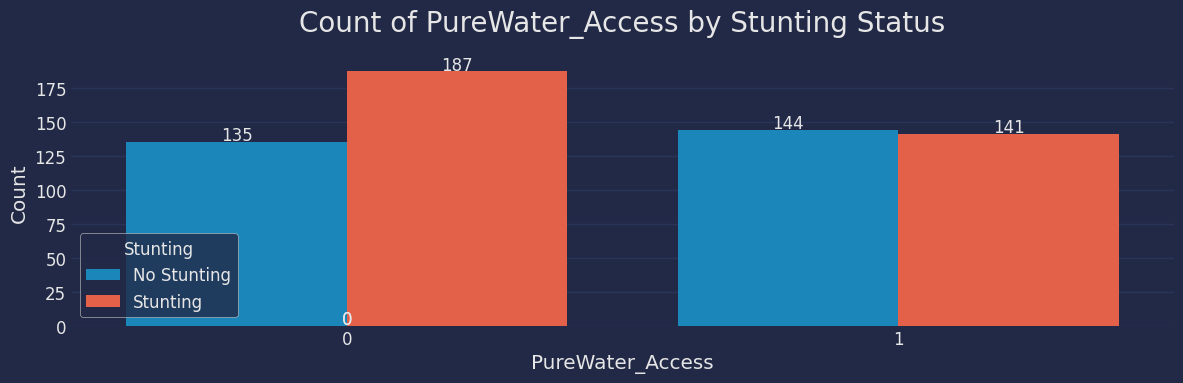

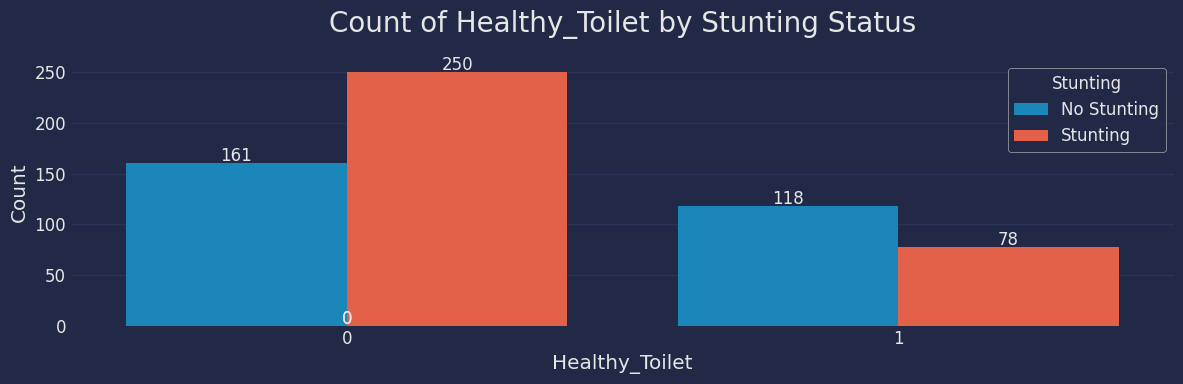

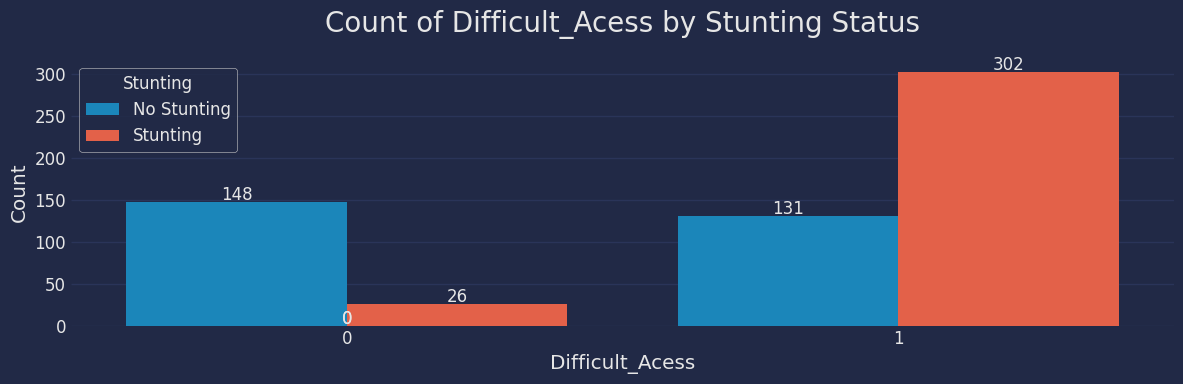

In [ ]:
for feature in features:
    # Second figure: Bar plot comparing counts by Stunting status
    plt.figure(figsize=(12, 4))
    ax = sns.countplot(x=feature, hue='Stunting', data=DataProc)
    plt.title(f'Count of {feature} by Stunting Status', size=20, pad=20)
    plt.xlabel(feature)
    plt.ylabel('Count')
    ax.legend(title='Stunting', labels=['No Stunting', 'Stunting'])

    # Add count annotations to bars
    for p in ax.patches:
        height = p.get_height()
        ax.annotate(f'{int(height)}',
                   (p.get_x() + p.get_width() / 2., height),
                   ha='center', va='center',
                   xytext=(0, 5),
                   textcoords='offset points')

    sns.despine(left=True, bottom=True)
    plt.tight_layout()
    plt.show()